# 주성분분석(PCA) 통합 실습

## 1. 주성분분석이란?

**주성분분석(Principal Component Analysis, PCA)**은 고차원 데이터를 저차원으로 축소하는 차원 축소 기법입니다.

### 주요 특징:
- **고차원 문제 해결**: 특성이 많을 때 (예: 이미지 80×80×3 = 19,200개 특성) 중요한 특성만 선별
- **비지도 학습**: 라벨 없이 데이터의 패턴을 찾아냄
- **차원 축소**: 30개 특성 → 2~3개 주성분으로 축소하여 시각화 가능
- **성능 향상**: 학습 시간 단축, 과적합 방지, 노이즈 제거

### 활용 분야:
- 상관관계 분석 및 시각화
- 다중공선성 해결
- 데이터 압축 및 전처리


In [3]:
# 필요한 라이브러리 import 및 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# 한글 폰트 설정 (matplotlib 한글 표시 문제 해결)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 음수 표시 문제 해결

print("라이브러리 import 및 한글 폰트 설정 완료!")

라이브러리 import 및 한글 폰트 설정 완료!


## 2. 데이터 로드 및 탐색적 데이터 분석

### 유방암 데이터셋 분석
- **30개의 특성**을 가진 유방암 진단 데이터
- **악성(malignant)과 양성(benign)** 두 클래스로 구분
- 상관관계 분석과 시각화를 통한 데이터 이해

In [2]:
# 유방암 데이터셋 로드 및 DataFrame 생성
cancer = load_breast_cancer()

# DataFrame 생성 (linter 오류 해결을 위한 수정)
cancer_data = cancer.data
cancer_feature_names = cancer.feature_names
cancer_target = cancer.target

df_cancer = pd.DataFrame(cancer_data, columns=cancer_feature_names)
df_cancer['target'] = cancer_target

print("데이터셋 기본 정보:")
print(f"데이터 크기: {df_cancer.shape}")
print(f"특성 개수: {len(cancer_feature_names)}")
print(f"클래스 분포:")
print(f"- 악성(0): {sum(cancer_target == 0)}개")
print(f"- 양성(1): {sum(cancer_target == 1)}개")
print("\n데이터 상위 5개 행:")
print(df_cancer.head())

데이터셋 기본 정보:
데이터 크기: (569, 31)
특성 개수: 30
클래스 분포:
- 악성(0): 212개
- 양성(1): 357개

데이터 상위 5개 행:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

  

악성 종양 데이터 크기: (212, 30)
양성 종양 데이터 크기: (357, 30)


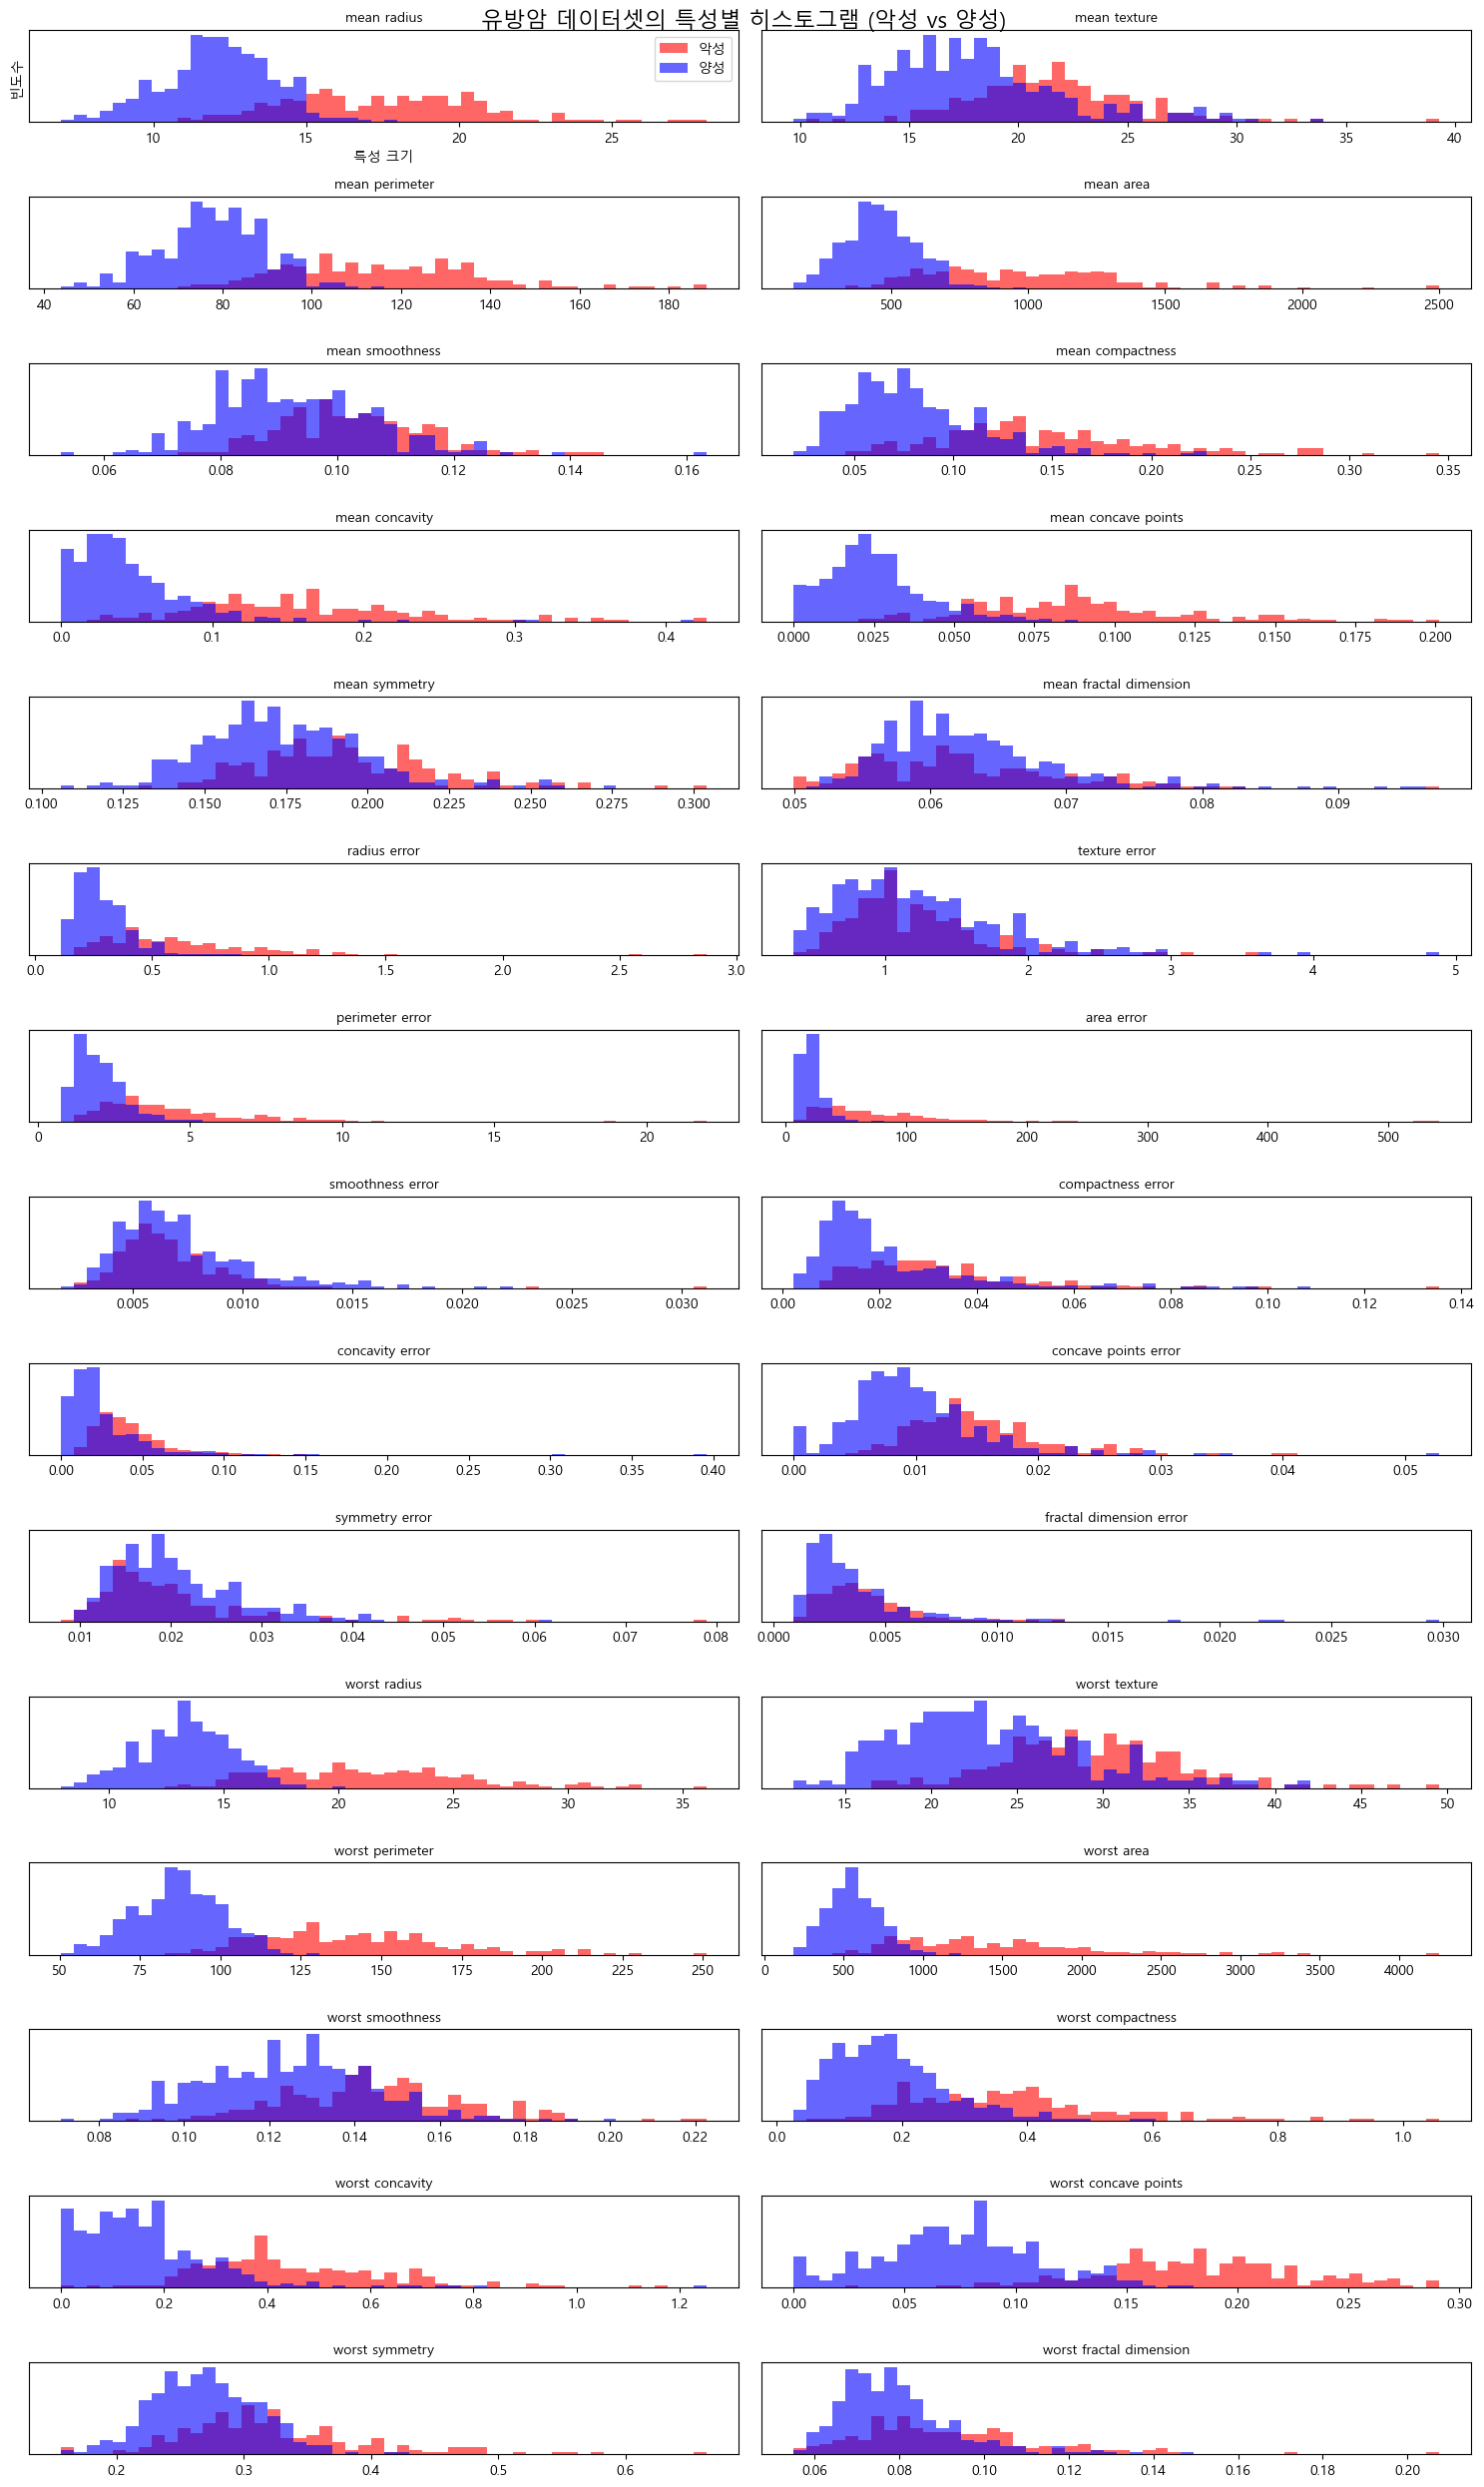

In [4]:
# 악성과 양성 종양 데이터 분리
malignant = cancer_data[cancer_target == 0]  # 악성 종양 데이터
benign = cancer_data[cancer_target == 1]     # 양성 종양 데이터

print(f"악성 종양 데이터 크기: {malignant.shape}")
print(f"양성 종양 데이터 크기: {benign.shape}")

# 30개 특성에 대한 히스토그램 생성 (15x2 배치)
fig, axes = plt.subplots(15, 2, figsize=(15, 25))
ax = axes.ravel()  # 축 정보를 1차원으로 변환

for i in range(30):  # 30개 특성에 대해
    # 구간 설정
    count, bins = np.histogram(cancer_data[:, i], bins=50)
    
    # 히스토그램 그리기
    ax[i].hist(malignant[:, i], bins=bins, color='red', alpha=0.6, label='악성')
    ax[i].hist(benign[:, i], bins=bins, color='blue', alpha=0.6, label='양성')
    
    # 제목 설정
    ax[i].set_title(cancer_feature_names[i], fontsize=10)
    ax[i].set_yticks([])  # y축 눈금 제거
    
    # 첫 번째 차트에만 라벨 및 범례 추가
    if i == 0:
        ax[i].set_xlabel('특성 크기')
        ax[i].set_ylabel('빈도수')
        ax[i].legend(['악성', '양성'], loc='best')

plt.tight_layout()  # 레이아웃 자동 조정
plt.suptitle('유방암 데이터셋의 특성별 히스토그램 (악성 vs 양성)', fontsize=16, y=0.995)
plt.show()

상관관계 행렬 생성 중...
상관관계 행렬 크기: (31, 31)


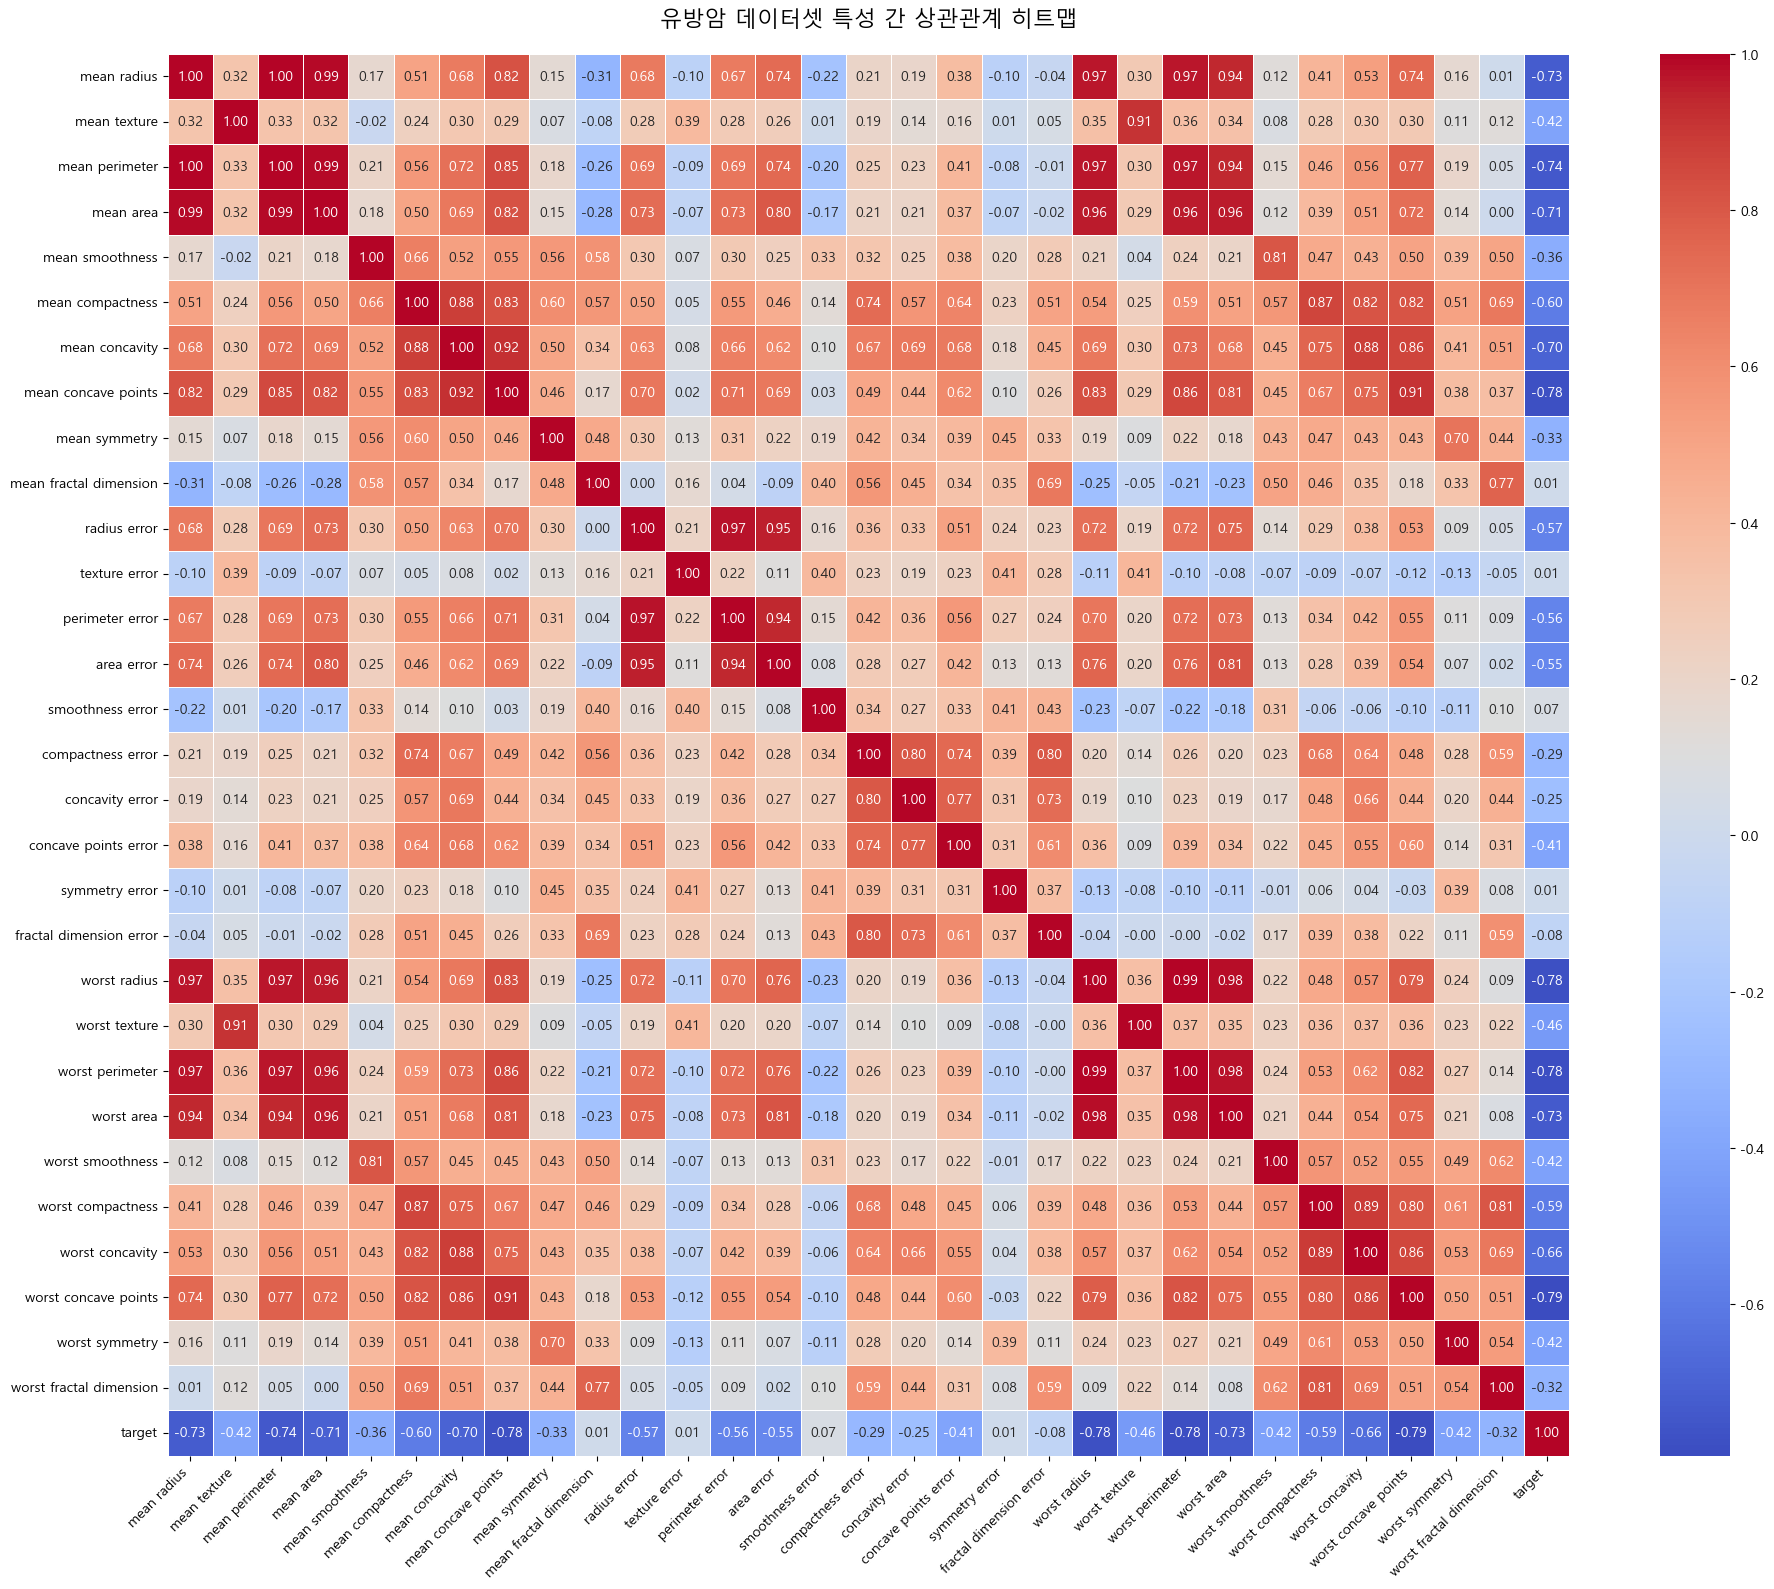


강한 상관관계 (|r| >= 0.8)를 가진 특성 쌍들:
- mean radius ↔ mean perimeter: 0.998
- mean radius ↔ mean area: 0.987
- mean radius ↔ mean concave points: 0.823
- mean radius ↔ worst radius: 0.970
- mean radius ↔ worst perimeter: 0.965
- mean radius ↔ worst area: 0.941
- mean texture ↔ worst texture: 0.912
- mean perimeter ↔ mean area: 0.987
- mean perimeter ↔ mean concave points: 0.851
- mean perimeter ↔ worst radius: 0.969


In [5]:
# 상관관계 히트맵 시각화
print("상관관계 행렬 생성 중...")
correlation_matrix = df_cancer.corr()  # 상관관계 계산
print(f"상관관계 행렬 크기: {correlation_matrix.shape}")

# 히트맵 생성
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, 
            annot=True,          # 셀에 값 표시
            cmap='coolwarm',     # 색상 (양의 관계: 빨강, 음의 관계: 파랑)
            fmt='.2f',           # 소수점 둘째자리까지 표시
            linewidths=0.5,      # 셀 사이 선 추가
            square=True)         # 정사각형 셀

plt.title('유방암 데이터셋 특성 간 상관관계 히트맵', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')  # x축 라벨 45도 회전
plt.yticks(rotation=0)               # y축 라벨 수평 유지
plt.tight_layout()                   # 레이아웃 자동 조정
plt.show()

# 강한 상관관계 (절댓값 0.8 이상) 찾기
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) >= 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_value
            ))

print(f"\n강한 상관관계 (|r| >= 0.8)를 가진 특성 쌍들:")
for pair in high_corr_pairs[:10]:  # 상위 10개만 출력
    print(f"- {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")

## 3. 주성분분석(PCA) 적용

### PCA의 필요성
- **다중공선성 문제**: 특성들 간의 높은 상관관계로 인한 문제
- **차원의 저주**: 특성이 많을수록 모델 성능 저하
- **시각화의 어려움**: 30차원 데이터를 2-3차원으로 축소하여 시각화

### PCA 과정
1. **데이터 표준화**: 각 특성의 스케일을 동일하게 맞춤
2. **공분산 행렬 계산**: 특성들 간의 관계 파악
3. **고유값/고유벡터 계산**: 주성분 방향 결정
4. **차원 축소**: 중요한 주성분만 선택하여 데이터 변환

손글씨 데이터셋 로드 중...
원본 데이터 크기: (1797, 64)
클래스 개수: 10
표준화 완료: 평균=0.000, 표준편차=0.976
PCA 변환 후 데이터 크기: (1797, 10)

주성분별 설명 분산 비율:
PC1: 0.1203 (12.03%)
PC2: 0.0956 (9.56%)
PC3: 0.0844 (8.44%)
PC4: 0.0650 (6.50%)
PC5: 0.0486 (4.86%)
PC6: 0.0421 (4.21%)
PC7: 0.0394 (3.94%)
PC8: 0.0339 (3.39%)
PC9: 0.0300 (3.00%)
PC10: 0.0293 (2.93%)

전체 설명 분산 비율: 0.5887 (58.87%)


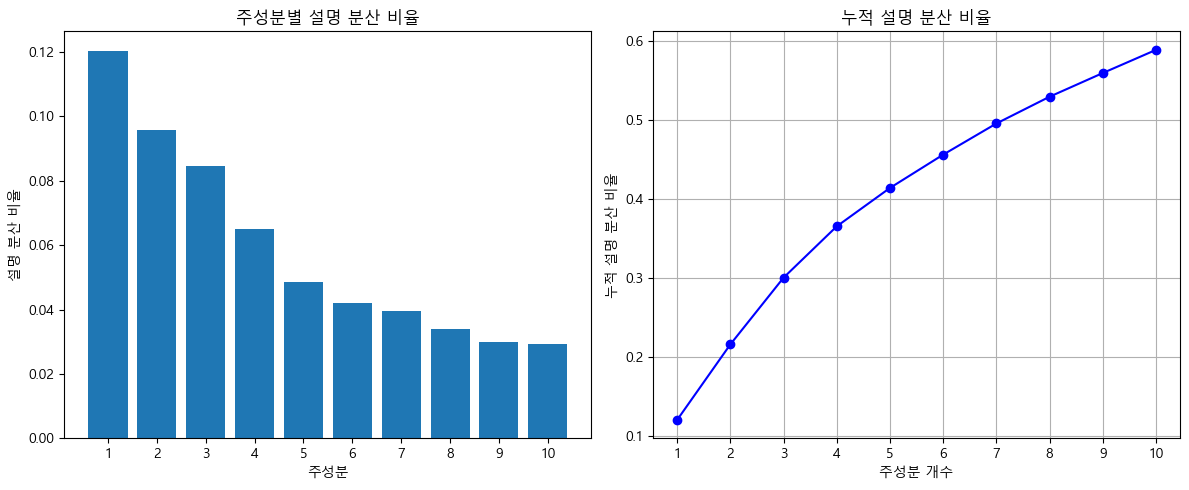

In [ ]:
# 손글씨 데이터셋으로 PCA 적용 예제
print("손글씨 데이터셋 로드 중...")
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print(f"원본 데이터 크기: {X_digits.shape}")
print(f"클래스 개수: {len(np.unique(y_digits))}")

# 1. 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_digits)
print(f"표준화 완료: 평균={X_scaled.mean():.3f}, 표준편차={X_scaled.std():.3f}")

# 2. PCA 적용 (10개 주성분)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA 변환 후 데이터 크기: {X_pca.shape}")

# 3. 주성분별 설명 분산 비율
explained_variance = pca.explained_variance_ratio_
print(f"\n주성분별 설명 분산 비율:")
for i, ratio in enumerate(explained_variance):
    print(f"PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print(f"\n전체 설명 분산 비율: {explained_variance.sum():.4f} ({explained_variance.sum()*100:.2f}%)")

# 4. 주성분별 설명 분산 시각화
plt.figure(figsize=(12, 5))

# 개별 주성분 설명 분산
plt.subplot(1, 2, 1)
plt.bar(range(1, 11), explained_variance)
plt.title('주성분별 설명 분산 비율')
plt.xlabel('주성분')
plt.ylabel('설명 분산 비율')
plt.xticks(range(1, 11))

# 누적 설명 분산
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), np.cumsum(explained_variance), 'bo-')
plt.title('누적 설명 분산 비율')
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명 분산 비율')
plt.xticks(range(1, 11))
plt.grid(True)

plt.tight_layout()
plt.show()

모델 성능 비교 (로지스틱 회귀)
1. 원본 데이터 (64차원)
   훈련 정확도: 1.0000
   테스트 정확도: 0.9733

2. 표준화된 데이터 (64차원)
   훈련 정확도: 0.9985
   테스트 정확도: 0.9711

3. PCA 적용 데이터 (10차원)
   훈련 정확도: 0.9005
   테스트 정확도: 0.8933


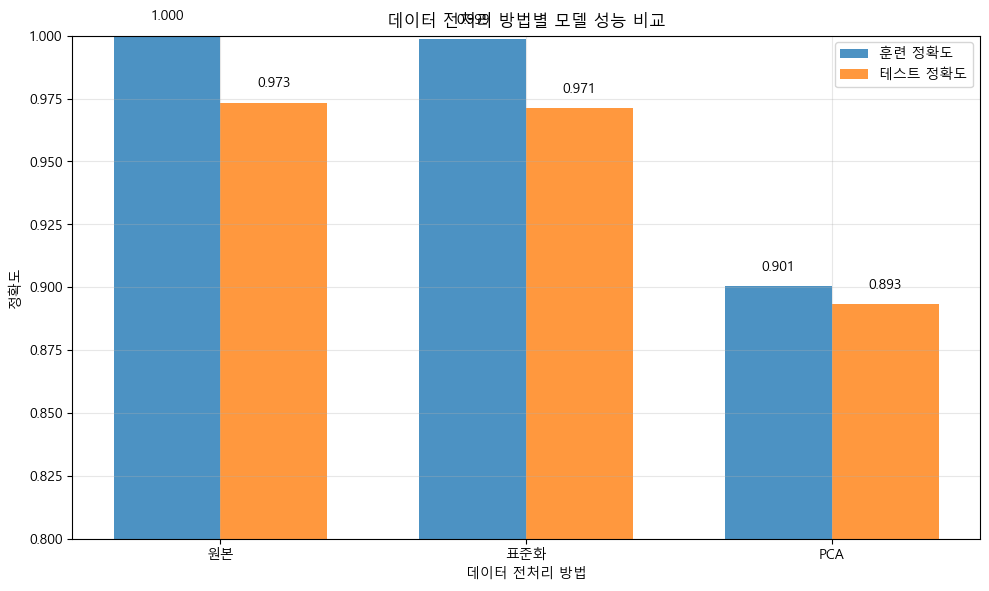


결론:
- PCA는 64차원 → 10차원으로 차원을 84% 축소
- 차원 축소에도 불구하고 높은 성능 유지
- 학습 속도 향상 및 메모리 사용량 감소 효과


In [7]:
# 모델 성능 비교: 원본 데이터 vs 표준화 vs PCA
print("=" * 50)
print("모델 성능 비교 (로지스틱 회귀)")
print("=" * 50)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.25, random_state=42
)

X_train_scaled, X_test_scaled, _, _ = train_test_split(
    X_scaled, y_digits, test_size=0.25, random_state=42
)

X_train_pca, X_test_pca, _, _ = train_test_split(
    X_pca, y_digits, test_size=0.25, random_state=42
)

# 로지스틱 회귀 모델
model = LogisticRegression(max_iter=1000, random_state=42)

# 1. 원본 데이터
model.fit(X_train, y_train)
train_score_original = model.score(X_train, y_train)
test_score_original = model.score(X_test, y_test)

print("1. 원본 데이터 (64차원)")
print(f"   훈련 정확도: {train_score_original:.4f}")
print(f"   테스트 정확도: {test_score_original:.4f}")

# 2. 표준화된 데이터
model.fit(X_train_scaled, y_train)
train_score_scaled = model.score(X_train_scaled, y_train)
test_score_scaled = model.score(X_test_scaled, y_test)

print("\n2. 표준화된 데이터 (64차원)")
print(f"   훈련 정확도: {train_score_scaled:.4f}")
print(f"   테스트 정확도: {test_score_scaled:.4f}")

# 3. PCA 적용 데이터
model.fit(X_train_pca, y_train)
train_score_pca = model.score(X_train_pca, y_train)
test_score_pca = model.score(X_test_pca, y_test)

print("\n3. PCA 적용 데이터 (10차원)")
print(f"   훈련 정확도: {train_score_pca:.4f}")
print(f"   테스트 정확도: {test_score_pca:.4f}")

# 성능 비교 시각화
methods = ['원본', '표준화', 'PCA']
train_scores = [train_score_original, train_score_scaled, train_score_pca]
test_scores = [test_score_original, test_score_scaled, test_score_pca]

x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_scores, width, label='훈련 정확도', alpha=0.8)
plt.bar(x + width/2, test_scores, width, label='테스트 정확도', alpha=0.8)

plt.xlabel('데이터 전처리 방법')
plt.ylabel('정확도')
plt.title('데이터 전처리 방법별 모델 성능 비교')
plt.xticks(x, methods)
plt.legend()
plt.ylim(0.8, 1.0)

# 각 막대 위에 정확도 값 표시
for i, (train, test) in enumerate(zip(train_scores, test_scores)):
    plt.text(i - width/2, train + 0.005, f'{train:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, test + 0.005, f'{test:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("결론:")
print("- PCA는 64차원 → 10차원으로 차원을 84% 축소")
print("- 차원 축소에도 불구하고 높은 성능 유지")
print("- 학습 속도 향상 및 메모리 사용량 감소 효과")
print("=" * 50)

PCA 시각화를 위한 2D, 3D 변환...


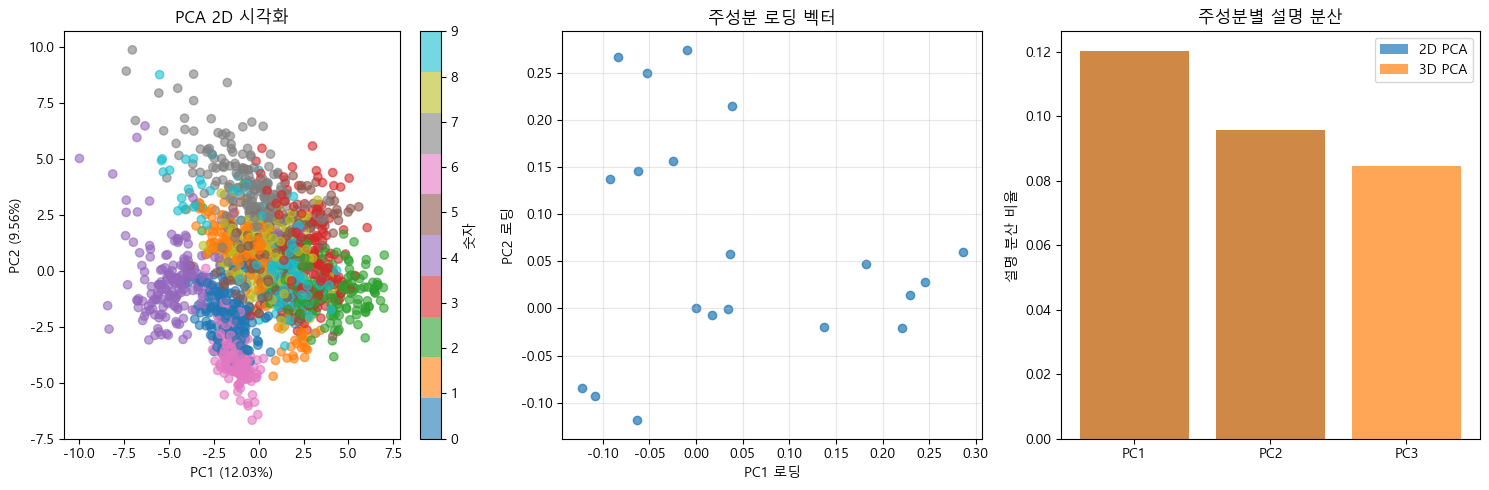

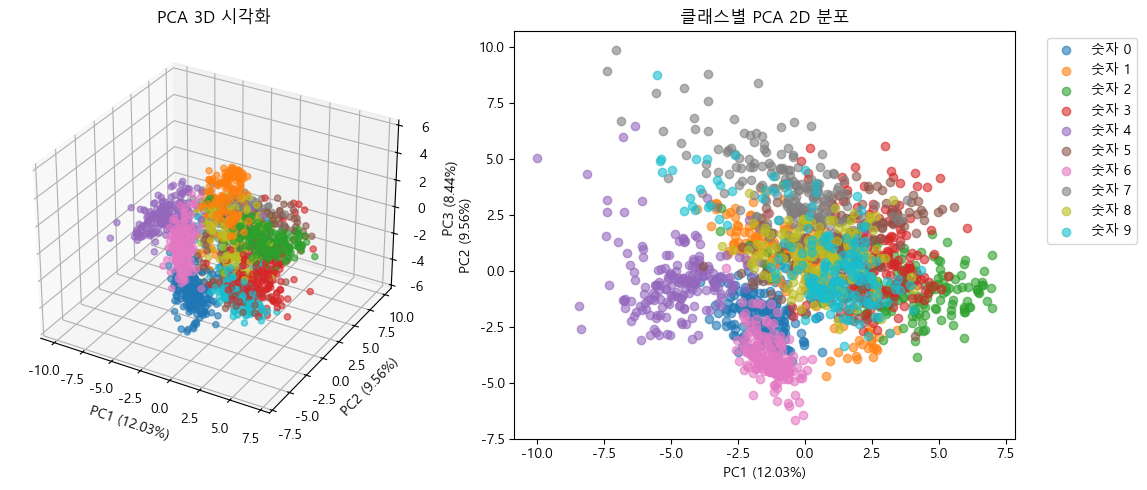

2D PCA 누적 설명 분산: 21.59%
3D PCA 누적 설명 분산: 30.04%
10D PCA 누적 설명 분산: 58.87%


In [8]:
# PCA 시각화: 2D 및 3D 표현
print("PCA 시각화를 위한 2D, 3D 변환...")

# 2D PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# 3D PCA
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# 2D 시각화
plt.figure(figsize=(15, 5))

# 2D 산점도
plt.subplot(1, 3, 1)
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_digits, cmap='tab10', alpha=0.6)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
plt.title('PCA 2D 시각화')
plt.colorbar(scatter, label='숫자')

# 주성분 로딩 벡터 시각화 (처음 몇 개 특성만)
plt.subplot(1, 3, 2)
features_to_show = 20  # 처음 20개 특성만 표시
loading_matrix = pca_2d.components_.T[:features_to_show, :]
plt.scatter(loading_matrix[:, 0], loading_matrix[:, 1], alpha=0.7)
plt.xlabel('PC1 로딩')
plt.ylabel('PC2 로딩')
plt.title('주성분 로딩 벡터')
plt.grid(True, alpha=0.3)

# 설명 분산 비율
plt.subplot(1, 3, 3)
explained_var_2d = pca_2d.explained_variance_ratio_
explained_var_3d = pca_3d.explained_variance_ratio_
plt.bar(['PC1', 'PC2'], explained_var_2d, alpha=0.7, label='2D PCA')
plt.bar(['PC1', 'PC2', 'PC3'], explained_var_3d, alpha=0.7, label='3D PCA')
plt.ylabel('설명 분산 비율')
plt.title('주성분별 설명 분산')
plt.legend()

plt.tight_layout()
plt.show()

# 3D 시각화
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))

# 3D 산점도
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                     c=y_digits, cmap='tab10', alpha=0.6)
ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax1.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax1.set_title('PCA 3D 시각화')

# 클래스별 분포 보기
ax2 = fig.add_subplot(1, 2, 2)
unique_digits = np.unique(y_digits)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_digits)))

for digit, color in zip(unique_digits, colors):
    mask = y_digits == digit
    ax2.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
               c=[color], label=f'숫자 {digit}', alpha=0.6)

ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
ax2.set_title('클래스별 PCA 2D 분포')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print(f"2D PCA 누적 설명 분산: {pca_2d.explained_variance_ratio_.sum():.2%}")
print(f"3D PCA 누적 설명 분산: {pca_3d.explained_variance_ratio_.sum():.2%}")
print(f"10D PCA 누적 설명 분산: {explained_variance.sum():.2%}")

## 4. 실습 결과 요약 및 결론

### 📊 실습 결과 정리

#### 1. **데이터 분석 단계**
- **유방암 데이터**: 30개 특성, 569개 샘플
- **히스토그램**: 악성/양성 종양의 특성별 분포 차이 확인
- **히트맵**: 특성 간 높은 상관관계 (다중공선성) 발견

#### 2. **PCA 적용 결과**
- **차원 축소**: 64차원 → 10차원 (84% 축소)
- **설명 분산**: 10개 주성분으로 전체 분산의 상당 부분 설명
- **시각화**: 2D/3D로 고차원 데이터 시각화 가능

#### 3. **모델 성능 비교**
- **원본 데이터**: 기준 성능
- **표준화**: 성능 향상
- **PCA**: 차원 축소에도 불구하고 높은 성능 유지

### 🎯 PCA의 장단점

#### ✅ **장점**
- **차원 축소**: 저장 공간 절약, 계산 속도 향상
- **노이즈 제거**: 중요하지 않은 특성 제거
- **시각화**: 고차원 데이터를 2D/3D로 시각화
- **다중공선성 해결**: 상관관계 높은 특성들 처리
- **과적합 방지**: 특성 수 감소로 일반화 성능 향상

#### ❌ **단점**
- **해석 어려움**: 새로운 특성(주성분)의 의미 파악 어려움
- **정보 손실**: 일부 분산 정보 손실
- **선형 변환**: 비선형 관계 포착 한계
- **스케일링 필요**: 사전 데이터 표준화 필수

### 💡 **실무 적용 팁**

1. **적절한 주성분 개수 선택**
   - 누적 설명 분산 85-95% 수준 권장
   - 엘보우 방법으로 최적 개수 결정

2. **전처리 중요성**
   - 반드시 표준화 후 PCA 적용
   - 이상치 제거 고려

3. **활용 분야**
   - 이미지 압축 및 인식
   - 유전체 데이터 분석
   - 금융 리스크 분석
   - 추천 시스템

### 🔍 **다음 단계 학습 방향**
- **t-SNE**: 비선형 차원 축소 기법
- **UMAP**: 최신 차원 축소 알고리즘
- **오토인코더**: 딥러닝 기반 차원 축소
- **특성 선택**: 필터/래퍼 방법론
